In [1]:
# !wget https://github.com/marcin119a/data/raw/refs/heads/main/data_gsn.zip
# !unzip data_gsn.zip &> /dev/null
# !rm data_gsn.zip

In [2]:
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import torch.nn.functional as F
from sklearn.metrics import f1_score, confusion_matrix
import pickle

torch.manual_seed(1)
checkpoints_dir = "checkpoints_data"
# checkpoints_dir = "checkpoints_data"
os.makedirs(checkpoints_dir, exist_ok=True)

In [3]:
all_pairs = [(i, j) for i in range(6) for j in range(i + 1, 6)]
pair_to_idx = {p: k for k, p in enumerate(all_pairs)}

def class_id_to_pair_and_split(class_id: int):
    pair_idx = class_id // 9
    split_idx = class_id % 9
    ca = split_idx + 1
    cb = 10 - ca
    i, j = all_pairs[pair_idx]
    return (i, j), (ca, cb)

def class_id_to_pair(class_id: int):
    pair_idx = class_id // 9
    return all_pairs[pair_idx]

def counts_to_class_id(counts):
    if isinstance(counts, torch.Tensor):
        c = counts.detach().cpu().tolist()
    else:
        c = list(counts)

    nz = [i for i, v in enumerate(c) if v > 0]
  
    a, b = sorted(nz)
    ca = int(c[a])
    pair_index = pair_to_idx[(a, b)]

    class_id = pair_index * 9 + (ca - 1)
    return class_id

In [4]:
class GSN(Dataset):
    def __init__(self, root, transform=None, transform_relabel=None):
        self.data_dir = os.path.join(root, "data")
        self.transform = transform
        self.transform_relabel = transform_relabel

        df = pd.read_csv(os.path.join(self.data_dir, "labels.csv"))
        self.names = df["name"].tolist()
        cols = ["squares", "circles", "up", "right", "down", "left"]
        self.labels = torch.tensor(df[cols].values, dtype=torch.float32)

    def __len__(self):
        return len(self.names)
    
    def __getitem__(self, index):
        name = self.names[index]
        img_path = os.path.join(self.data_dir, name)

        img = Image.open(img_path).convert("L")
        img = transforms.ToTensor()(img)
        
        if self.transform:
            img = self.transform(img)

        cnt = self.labels[index]

        if self.transform_relabel:
            img, cnt = self.transform_relabel(img, cnt)
        
        cls = counts_to_class_id(cnt)

        return img, cls, cnt



In [5]:
class Augmentation:
    def __init__(self, p_hflip=0.5, p_vflip=0.5):
        self.p_hflip = p_hflip
        self.p_vflip = p_vflip

    def __call__(self, img, cnt):
        cnt = cnt.clone()

        k = torch.randint(0, 4, (1,)).item()
        if k > 0:
            img = torch.rot90(img, k=-k, dims=[1,2])
            dirs = cnt[2:6]
            dirs = torch.roll(dirs, shifts=k)
            cnt[2:6] = dirs

        if torch.rand(1).item() < self.p_hflip:
            img = torch.flip(img, dims=[2])
            cnt[[3, 5]] = cnt[[5, 3]]
        
        if torch.rand(1).item() < self.p_vflip:
            img = torch.flip(img, dims=[1])
            cnt[[2, 4]] = cnt[[4, 2]]

        return img, cnt


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self, cls_hidden=256, cnt_hidden=256, dropout=0.3):
        super().__init__()

        self.backbone = nn.Sequential(                              # (64, 1, 28, 28)
            nn.Conv2d(1, 8, 3, stride=1, padding=1), nn.ReLU(),     # (64, 8, 28 28)  
            nn.Conv2d(8, 16, 3, stride=1, padding=1), nn.ReLU(),    # (64, 16, 28, 28)
            nn.Conv2d(16, 32, 3, stride=1, padding=1), nn.ReLU(),   # (64, 32, 28, 28)
            nn.Conv2d(32, 64, 3, stride=1, padding=1), nn.ReLU(),   # (64, 64, 28, 28)
            nn.Flatten(start_dim=1),                                # (64, 64 * 28 * 28)
            nn.Linear(64 * 28 * 28, 256), nn.ReLU()
        )

        self.head_cls = nn.Sequential(
            nn.Linear(256, cls_hidden),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(cls_hidden, 135),
            nn.LogSoftmax(dim=1)
        )

        self.head_cnt = nn.Sequential(
            nn.Linear(256, cnt_hidden),
            nn.ReLU(),
            nn.Linear(cnt_hidden, 6)
        )
    
    def forward(self, x):
        x = self.backbone(x)

        cls = self.head_cls(x)  # (64, 135)
        cnt = self.head_cnt(x)  # (64, 6)

        return cls, cnt

In [7]:
def train_epoch(
    net: torch.nn.Module,
    device: torch.device,
    train_loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    mode: str,
    lambda_cnt = None,
):
    net.train()
    total_loss = 0.0
    n_total = 0
    
    for img, cls_target, cnt_target in train_loader:
        img, cls_target, cnt_target = img.to(device), cls_target.long().to(device), cnt_target.to(device)

        optimizer.zero_grad()

        cls_pred, cnt_pred = net(img)
        
        cls_loss = F.nll_loss(cls_pred, cls_target)
        cnt_loss = F.smooth_l1_loss(cnt_pred, cnt_target)

        if mode == "cls_only":
            loss = cls_loss
        elif mode == "reg_only":
            loss = cnt_loss
        else:
            loss = cls_loss + lambda_cnt * cnt_loss

        loss.backward()
        optimizer.step()

        B = len(img)

        total_loss += loss.item() * B
        n_total += B

    epoch_loss = total_loss / n_total
    return epoch_loss


In [8]:
def eval_epoch(
    net: torch.nn.Module,
    device: torch.device,
    test_loader: torch.utils.data.DataLoader,
    epoch: int,
    mode: str,
    lambda_cnt = None,
    verbose: bool = False,
):
    net.eval()
    total_loss = total_cls_loss = total_cnt_loss = 0.0
    n_total = 0
    correct = 0

    sum_sq_diff = 0.0
    n_cnt = 0

    with torch.no_grad():
        for img, cls_target, cnt_target in test_loader:
            img, cls_target, cnt_target = img.to(device), cls_target.long().to(device), cnt_target.to(device)

            cls_pred, cnt_pred = net(img)

            cls_loss = F.nll_loss(cls_pred, cls_target)
            cnt_loss = F.smooth_l1_loss(cnt_pred, cnt_target)

            if mode == "cls_only":
                loss = cls_loss
            elif mode == "reg_only":
                loss = cnt_loss
            else:
                loss = cls_loss + lambda_cnt * cnt_loss

            total_loss += loss.item() * len(img)
            total_cls_loss += cls_loss.item() * len(img)
            total_cnt_loss += cnt_loss.item() * len(img)
            n_total += len(img)

            pred = cls_pred.argmax(dim=1)
            correct += (pred == cls_target).sum().item()

            diff = cnt_pred - cnt_target
            sum_sq_diff += (diff ** 2).sum().item()
            n_cnt += diff.numel()

    epoch_loss = total_loss / n_total
    epoch_cls_loss = total_cls_loss / n_total
    epoch_cnt_loss = total_cnt_loss / n_total
    epoch_acc = correct / n_total

    epoch_rmse = (sum_sq_diff / n_cnt) ** 0.5

    if verbose:
        print(
            f"Eval Epoch: {epoch} | "
            f"acc: {epoch_acc:.4f} | "
            f"loss: {epoch_loss:.4f} | "
            f"cls_loss: {epoch_cls_loss:.4f} | "
            f"cnt_loss: {epoch_cnt_loss:.4f}"
        )
    return epoch_loss, epoch_acc, epoch_rmse

In [9]:
def evaluate_metrics(net, device, loader):
    net.eval()

    all_cls_true = []
    all_cls_pred = []
    all_cnt_true = []
    all_cnt_pred = []

    with torch.no_grad():
        for img, cls_target, cnt_target in loader:
            img = img.to(device)

            cls_logits, cnt_pred = net(img)
            cls_pred = cls_logits.argmax(dim=1)

            all_cls_true.append(cls_target)
            all_cls_pred.append(cls_pred.to("cpu"))            
            all_cnt_true.append(cnt_target)
            all_cnt_pred.append(cnt_pred.to("cpu"))

    cls_true = torch.cat(all_cls_true)
    cls_pred = torch.cat(all_cls_pred)
    cnt_true = torch.cat(all_cnt_true)
    cnt_pred = torch.cat(all_cnt_pred)

    acc = (cls_true == cls_pred).float().mean().item()
    print(f"Top-1 accuracy: {acc}" )  

    cls_true_np = cls_true.numpy() 
    cls_pred_np = cls_pred.numpy() 
    macro_f1 = f1_score(cls_true_np, cls_pred_np, average="macro")
    print(f"Macro F1:{macro_f1}")

    correct_pair = 0
    total = len(cls_true)
    for t, p in zip(cls_true.tolist(), cls_pred.tolist()):
        if class_id_to_pair(int(t)) == class_id_to_pair(int(p)):
            correct_pair += 1
    pair_acc = correct_pair / total
    print(f"Per-pair accuracy: {pair_acc}")

    diff = cnt_pred - cnt_true
    mse_per_class = (diff ** 2).mean(dim=0)
    rmse_per_class = torch.sqrt(mse_per_class)
    mae_per_class = diff.abs().mean(dim=0)
    overall_rmse = torch.sqrt((diff ** 2).mean()).item()
    overall_mae = diff.abs().mean().item()  
    print(f"RMSE per class: {rmse_per_class.tolist()}")
    print(f"MAE per class: {mae_per_class.tolist()}")
    print(f"Overall RMSE: {overall_rmse}")
    print(f"Overall MAE: {overall_mae}")

    cm = confusion_matrix(cls_true_np, cls_pred_np, labels=np.arange(135))

    return {
        "acc": acc,
        "macro_f1": macro_f1,
        "pair_acc": pair_acc,
        "rmse_per_class": rmse_per_class.tolist(),
        "mae_per_class": mae_per_class.tolist(),
        "overall_rmse": overall_rmse,
        "overall_mae": overall_mae,
        "confusion_matrix": cm,
    }

In [10]:
def create_loaders(root=".", batch_size=64, test_batch_size=1000, device=torch.device("cpu")):
    if device.type == "cuda":
        num_workers = min(8, os.cpu_count() or 2)
    else:
        num_workers = 0

    pin = (device.type == "cuda")
    loader_kwargs = dict(
        num_workers=num_workers,
        pin_memory=pin,
        persistent_workers=False,
    )
    if num_workers > 0:
        loader_kwargs["prefetch_factor"] = 4

    train_aug = Augmentation()
    train_full = GSN(root=root, transform_relabel=train_aug)
    test_full = GSN(root=root)

    train_dataset = Subset(train_full, range(0, 9000))
    test_dataset = Subset(test_full, range(9000, 10000))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **loader_kwargs)
    test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, **loader_kwargs)
    return train_loader, test_loader


In [11]:
epochs = 100
lr = 1e-3
batch_size = 64
test_batch_size = 1000

cls_hidden = 256
cnt_hidden = 256
dropout = 0.3
patience = 10
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu")

def train_model(
    mode: str,
    lambda_cnt = None,
):
    
    if device.type == "cuda":
        torch.backends.cudnn.benchmark = True
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True

    train_loader, test_loader = create_loaders(
        root=".",
        batch_size=64,
        test_batch_size=1000,
        device=device,
    )

    net = NeuralNetwork(cls_hidden, cnt_hidden, dropout).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)

    history = {
        "train_loss": [],
        "eval_loss": [],
        "eval_acc": [],
        "eval_rmse": [],
    }

    best_eval_loss = float("inf")
    best_eval_loss_acc = 0.0
    best_state = None
    bad_epochs = 0
    best_epoch = 0

    for epoch in range(1, epochs+1):
        train_loss = train_epoch(
            net,
            device,
            train_loader,
            optimizer,
            mode,
            lambda_cnt=lambda_cnt,
        )

        eval_loss, eval_acc, eval_rmse = eval_epoch(
            net,
            device,
            test_loader,
            epoch,
            mode,
            lambda_cnt=lambda_cnt,
            verbose=True
        )

        history["train_loss"].append(train_loss)
        history["eval_loss"].append(eval_loss)
        history["eval_acc"].append(eval_acc)
        history["eval_rmse"].append(eval_rmse)

        if eval_loss < best_eval_loss - 1e-4:
            best_eval_loss = eval_loss
            best_eval_loss_acc = eval_acc
            best_state = {k: v.cpu().clone() for k,v in net.state_dict().items()}
            bad_epochs = 0
            best_epoch = epoch
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(
                    f"Early stop at epoch {epoch}. "
                    f"Best val loss: {best_eval_loss:.4f}, "
                    f"with acc: {best_eval_loss_acc:.4f}, "
                    f"after epoch: {best_epoch}"
                )
                break

    if best_state is not None:
        net.load_state_dict(best_state)

    metrics = evaluate_metrics(net, device, test_loader)

    return net, history, metrics

In [12]:
results = {}

settings = [
    ("cls_only", None),
    ("reg_only", None),
    ("multitask", 0.3),
    ("multitask", 0.5),
    ("multitask", 1.0),
]

for mode, lambda_cnt in settings:
    if lambda_cnt is not None:
        print(f"\n=== Training mode={mode}, lambda_cnt={lambda_cnt} ===")
        net, history, metrics = train_model(mode=mode, lambda_cnt=lambda_cnt)

        results[(mode, lambda_cnt)] = {
            "history": history,
            "metrics": metrics,
        }

        lambda_str = str(lambda_cnt).replace(".", "_")
        model_path = os.path.join(checkpoints_dir, f"model_{mode}_lambda{lambda_str}.pt")
        torch.save(net.state_dict(), model_path)
        print(f"Saved model to {model_path}")

    else:
        print(f"\n=== Training mode={mode} ===")
        net, history, metrics = train_model(mode=mode)

        results[mode] = {
            "history": history,
            "metrics": metrics,
        }

        model_path = os.path.join(checkpoints_dir, f"model_{mode}.pt")
        torch.save(net.state_dict(), model_path)
        print(f"Saved model to {model_path}")


all_results_path = os.path.join(checkpoints_dir, "all_results.pkl")
with open(all_results_path, "wb") as f:
    pickle.dump(results, f)
print(f"\nSaved all results dict to {all_results_path}")



=== Training mode=cls_only ===
Eval Epoch: 1 | acc: 0.0050 | loss: 4.6738 | cls_loss: 4.6738 | cnt_loss: 1.4956
Eval Epoch: 2 | acc: 0.0230 | loss: 4.5925 | cls_loss: 4.5925 | cnt_loss: 1.5121
Eval Epoch: 3 | acc: 0.0580 | loss: 3.7666 | cls_loss: 3.7666 | cnt_loss: 1.4842
Eval Epoch: 4 | acc: 0.1340 | loss: 2.8761 | cls_loss: 2.8761 | cnt_loss: 1.4905
Eval Epoch: 5 | acc: 0.2210 | loss: 2.4580 | cls_loss: 2.4580 | cnt_loss: 1.4961
Eval Epoch: 6 | acc: 0.3090 | loss: 1.9299 | cls_loss: 1.9299 | cnt_loss: 1.5284
Eval Epoch: 7 | acc: 0.3520 | loss: 1.7129 | cls_loss: 1.7129 | cnt_loss: 1.5362
Eval Epoch: 8 | acc: 0.3720 | loss: 1.5860 | cls_loss: 1.5860 | cnt_loss: 1.5285
Eval Epoch: 9 | acc: 0.3770 | loss: 1.5047 | cls_loss: 1.5047 | cnt_loss: 1.5330
Eval Epoch: 10 | acc: 0.3680 | loss: 1.4819 | cls_loss: 1.4819 | cnt_loss: 1.5335
Eval Epoch: 11 | acc: 0.3970 | loss: 1.4616 | cls_loss: 1.4616 | cnt_loss: 1.5304
Eval Epoch: 12 | acc: 0.4030 | loss: 1.4349 | cls_loss: 1.4349 | cnt_loss: 

In [13]:
with open(os.path.join(checkpoints_dir, "all_results.pkl"), "rb") as f:
    results = pickle.load(f)

In [25]:
rows = []
for key, res in results.items():
    if isinstance(key, tuple):
        mode, lambda_cnt = key
    else:
        mode, lambda_cnt = key, None

    m = res["metrics"]
    rows.append({
        "mode": mode,
        "lambda_cnt": lambda_cnt,
        "acc": m["acc"],
        "macro_f1": m["macro_f1"],
        "pair_acc": m["pair_acc"],
        "overall_rmse": m["overall_rmse"],
        "overall_mae": m["overall_mae"],
    })

summary_df = pd.DataFrame(rows)
# print(summary_df.to_string(index=False))
summary_df

,mode,lambda_cnt,acc,macro_f1,pair_acc,overall_rmse,overall_mae
0,cls_only,NaN,0.514,0.481699,0.942,3.109721,1.849599
1,reg_only,NaN,0.008,0.000781,0.046,0.532545,0.291426
2,multitask,0.3,0.487,0.454560,0.948,0.609252,0.362347
3,multitask,0.5,0.507,0.462247,0.950,0.584773,0.354032
4,multitask,1.0,0.475,0.449045,0.951,0.583136,0.340104


In [15]:
rows = []
index = []
shape_classes = ["square", "circle", "up", "right", "down", "left"]

for key, res in results.items():
    if isinstance(key, tuple):
        mode, lambda_cnt = key
    else:
        mode, lambda_cnt = key, None

    m = res["metrics"]
    rmse_vals = m["rmse_per_class"]
    mae_vals = m["mae_per_class"]

    index.append((mode, lambda_cnt, "rmse"))
    rows.append(rmse_vals)

    index.append((mode, lambda_cnt, "mae"))
    rows.append(mae_vals)

multi_index = pd.MultiIndex.from_tuples(
    index, names=["mode", "lambda_cnt", "metric"]
)

per_class_all_df = pd.DataFrame(rows, index=multi_index, columns=shape_classes)
# print(per_class_all_df.to_markdown())
per_class_all_df

square    circle        up     right      down  \
mode      lambda_cnt metric                                                     
cls_only  NaN        rmse    2.890897  3.076180  3.162668  3.082885  3.059210   
                     mae     1.700412  1.785388  1.848892  1.844499  1.839822   
reg_only  NaN        rmse    0.454719  0.501130  0.540694  0.549820  0.568486   
                     mae     0.251632  0.263145  0.314832  0.292246  0.313742   
multitask 0.3        rmse    0.495199  0.566727  0.598200  0.646332  0.630932   
                     mae     0.286507  0.349295  0.338939  0.373920  0.393178   
          0.5        rmse    0.503042  0.494145  0.587120  0.616931  0.579617   
                     mae     0.304434  0.285553  0.382343  0.364167  0.361398   
          1.0        rmse    0.516819  0.532295  0.567505  0.602791  0.617215   
                     mae     0.301481  0.328350  0.346352  0.325169  0.364632   

                                 left  
mode      lambda_cnt metric            
cls_only  NaN        rmse    3.366987  
                     mae     2.078581  
reg_only  NaN        rmse    0.570872  
                     mae     0.312958  
multitask 0.3        rmse    0.697901  
                     mae     0.432245  
          0.5        rmse    0.702322  
                     mae     0.426296  
          1.0        rmse    0.650745  
                     mae     0.374641

In [16]:
def plot_confusion_matrix_full(cm, title="Confusion matrix (135 classes)"):
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(cm, interpolation="nearest", aspect="auto")
    fig.colorbar(im, ax=ax)
    ax.set_xlabel("Predicted class")
    ax.set_ylabel("True class")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

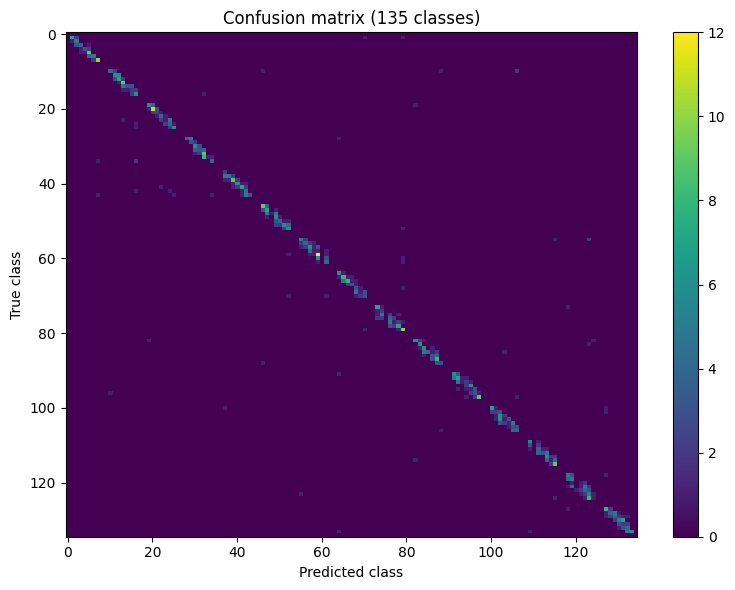

In [17]:
mt_key = ("multitask", 0.3)
cm = results[mt_key]["metrics"]["confusion_matrix"]
plot_confusion_matrix_full(cm)

In [18]:
import matplotlib.pyplot as plt

def plot_history(history, mode, title_prefix=""):
    epochs = range(1, len(history["train_loss"]) + 1)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(epochs, history["train_loss"], label="Train loss")
    ax.plot(epochs, history["eval_loss"], label="Val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"{title_prefix}Loss over epochs")
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    plt.show()

    if mode != "reg_only":
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(epochs, history["eval_acc"])
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{title_prefix}Validation accuracy over epochs")
        ax.grid(True)
        fig.tight_layout()
        plt.show()

    if mode != "cls_only":
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(epochs, history["eval_rmse"])
        ax.set_xlabel("Epoch")
        ax.set_ylabel("RMSE")
        ax.set_title(f"{title_prefix}Validation RMSE over epochs")
        ax.grid(True)
        fig.tight_layout()
        plt.show()


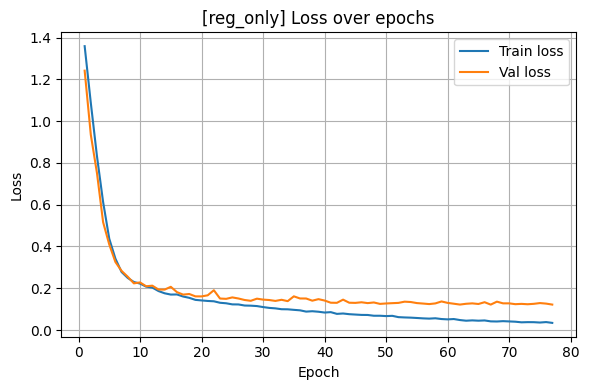

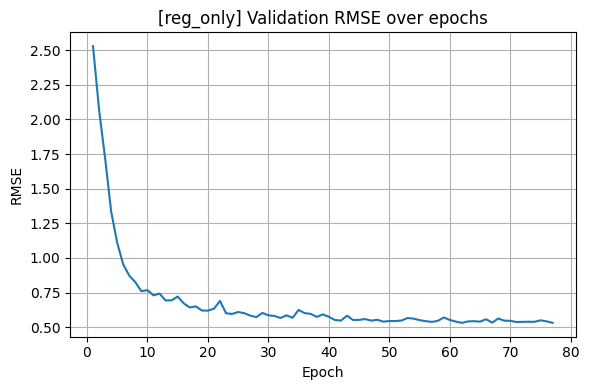

In [19]:
plot_history(results["reg_only"]["history"], mode="reg_only", title_prefix="[reg_only] ")

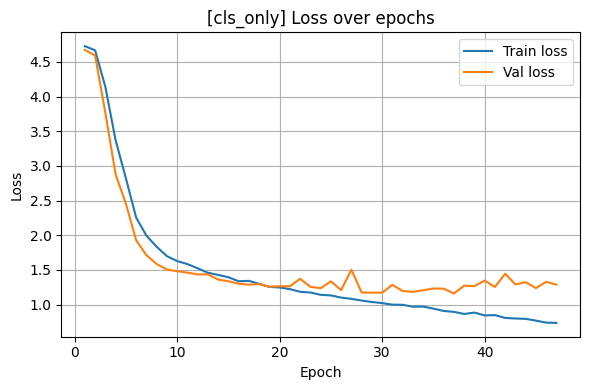

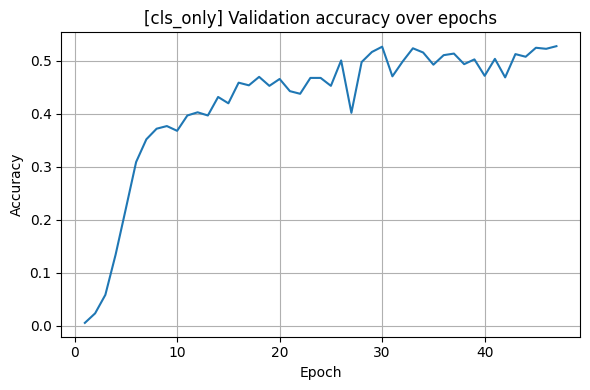

In [20]:
plot_history(results["cls_only"]["history"], mode="cls_only", title_prefix="[cls_only] ")

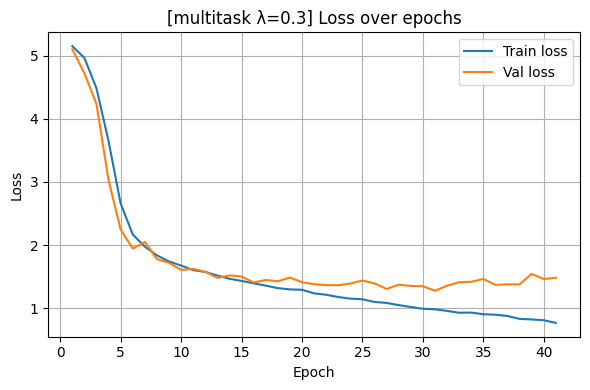

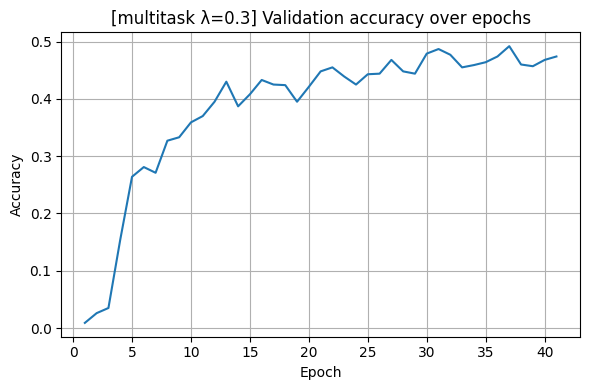

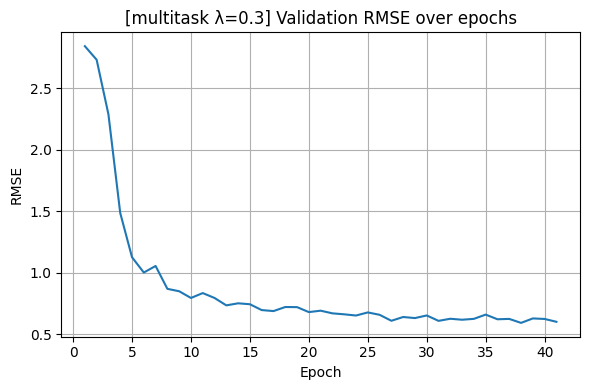

In [21]:
plot_history(results[("multitask", 0.3)]["history"], mode="multitask", title_prefix="[multitask λ=0.3] ")

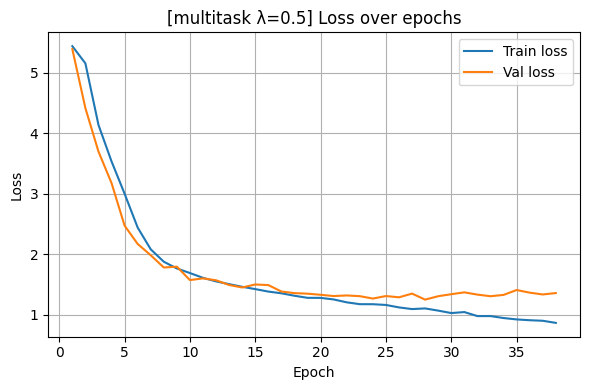

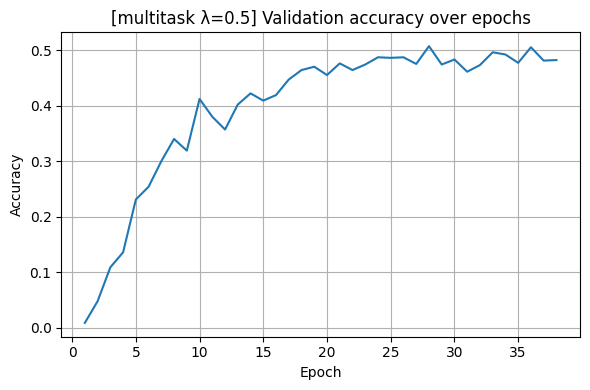

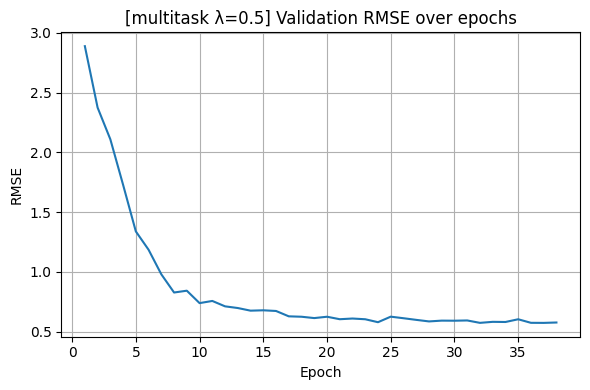

In [22]:
plot_history(results[("multitask", 0.5)]["history"], mode="multitask", title_prefix="[multitask λ=0.5] ")

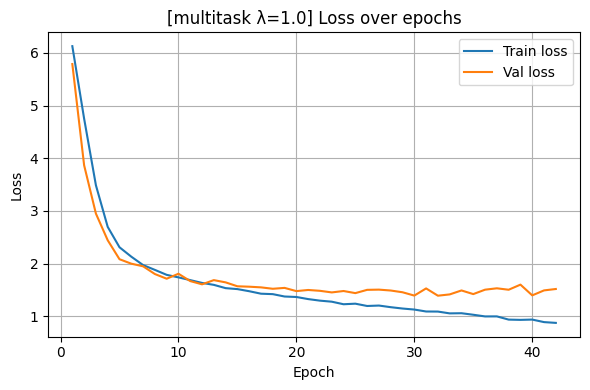

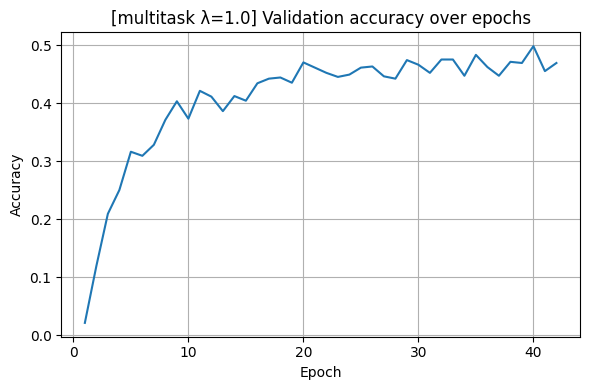

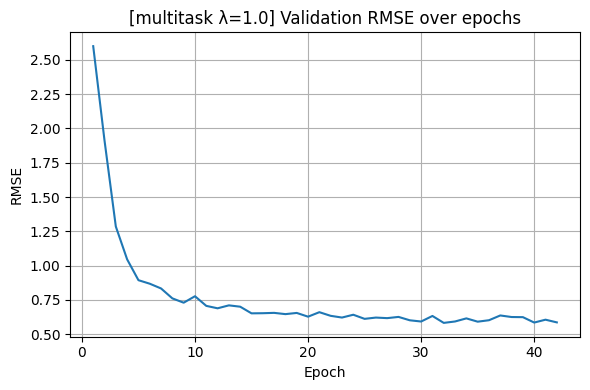

In [23]:
plot_history(results[("multitask", 1.0)]["history"], mode="multitask", title_prefix="[multitask λ=1.0] ")

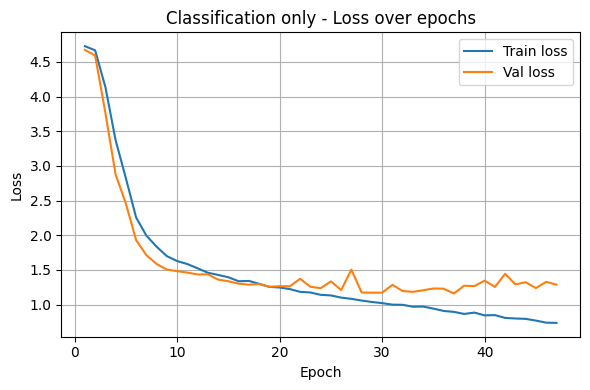

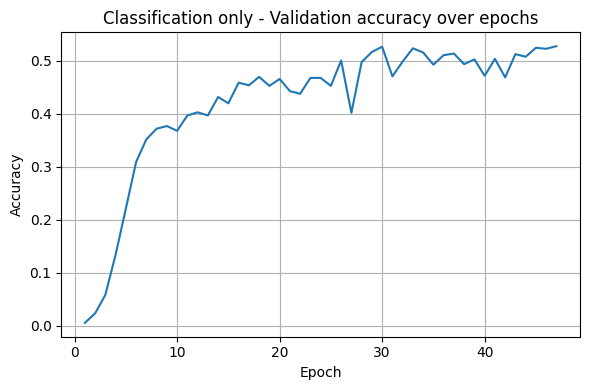

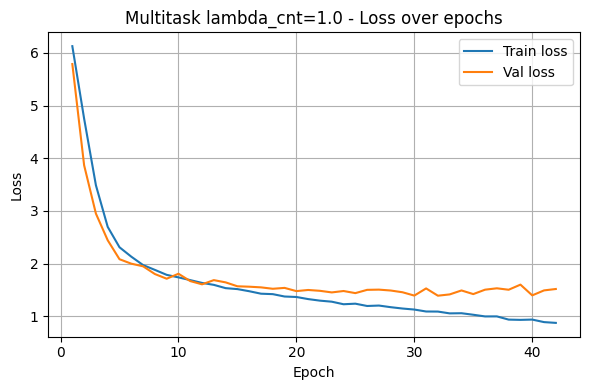

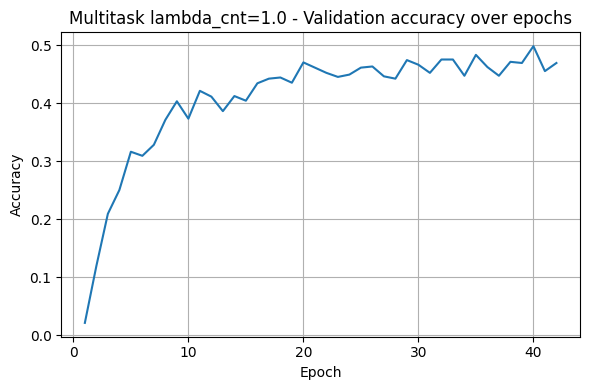

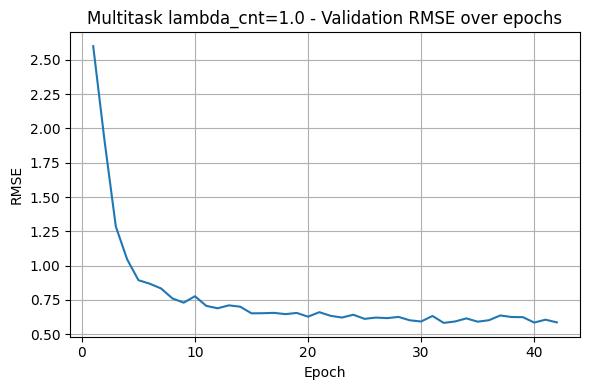

In [30]:
import matplotlib.pyplot as plt

def plot_history(history, mode, title_prefix=""):
    # Helper to build a safe-ish filename from the title prefix and a suffix
    def make_filename(suffix):
        base = f"{title_prefix}{suffix}".strip()
        return base.replace(" ", "_") + ".png"

    epochs = range(1, len(history["train_loss"]) + 1)

    # --- Loss plot ---
    fig, ax = plt.subplots(figsize=(6, 4))
    ax.plot(epochs, history["train_loss"], label="Train loss")
    ax.plot(epochs, history["eval_loss"], label="Val loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_title(f"{title_prefix}Loss over epochs")
    ax.legend()
    ax.grid(True)
    fig.tight_layout()
    fig.savefig(make_filename("loss"), dpi=300, bbox_inches="tight")
    plt.show()

    # --- Accuracy plot (if not reg-only) ---
    if mode != "reg_only":
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(epochs, history["eval_acc"])
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Accuracy")
        ax.set_title(f"{title_prefix}Validation accuracy over epochs")
        ax.grid(True)
        fig.tight_layout()
        fig.savefig(make_filename("accuracy"), dpi=300, bbox_inches="tight")
        plt.show()

    # --- RMSE plot (if not cls-only) ---
    if mode != "cls_only":
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.plot(epochs, history["eval_rmse"])
        ax.set_xlabel("Epoch")
        ax.set_ylabel("RMSE")
        ax.set_title(f"{title_prefix}Validation RMSE over epochs")
        ax.grid(True)
        fig.tight_layout()
        fig.savefig(make_filename("rmse"), dpi=300, bbox_inches="tight")
        plt.show()

# Your existing calls
# plot_history(results["reg_only"]["history"], mode="reg_only", title_prefix="Regression only - ")
plot_history(results["cls_only"]["history"], mode="cls_only", title_prefix="Classification only - ")
plot_history(results[("multitask", 1.0)]["history"], mode="multitask", title_prefix="Multitask lambda_cnt=1.0 - ")
